*Think Linear Algebra* is not for sale yet, but if you would like to support this project, you can [buy me a coffee](https://buymeacoffee.com/allendowney).

# Regression

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkLinearAlgebra/blob/main/chapters/regression.ipynb).

In [62]:
# temporary hack to make autoreload work on Colab
import importlib, sys
sys.modules["imp"] = importlib

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
from os.path import basename, exists


def download(url, filename=None):
    if filename is None:
        filename = basename(url)
        
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkLinearAlgebra/raw/main/utils.py")

In [64]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sp

from utils import decorate, underride

In [65]:
from utils import set_precision

set_precision(4)

## Section

In [66]:
x = np.array([2, 1, 0]) + 0.1
y = 0.5 + 0.8 * x + [-0.1, -0.2, 0.3]
y

array([2.08, 1.18, 0.88])

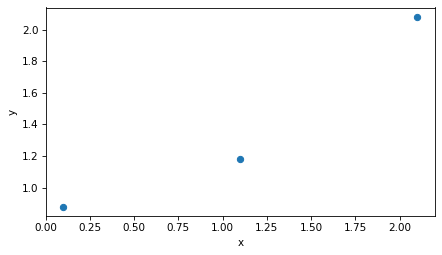

In [67]:
plt.plot(x, y, 'o')
decorate(xlabel='x', ylabel='y')

In [68]:
X = np.column_stack((np.ones_like(x), x))
X

array([[1. , 2.1],
       [1. , 1.1],
       [1. , 0.1]])

In [69]:
beta = np.array([1, 1])
beta

array([1, 1])

In [70]:
X @ beta

array([3.1, 2.1, 1.1])

In [71]:
r = y - X @ beta
r

array([-1.02, -0.92, -0.22])

In [72]:
np.dot(r, r)

1.9352

In [73]:
def rss_func(beta, X, y):
    r = y - X @ beta
    return np.dot(r, r)

In [74]:
rss_func(beta, X, y)

1.9352

In [75]:
from scipy.optimize import minimize

result = minimize(rss_func, beta, args=(X, y))
result.message

'Optimization terminated successfully.'

In [76]:
result.nfev

15

In [77]:
beta_hat = result.x
beta_hat

array([0.72, 0.6 ])

In [78]:
rss_func(beta_hat, X, y)

0.0600

In [79]:
intercept, slope = beta_hat
y_hat = intercept + slope * x

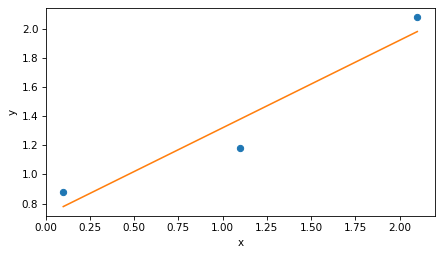

In [80]:
plt.plot(x, y, 'o')
plt.plot(x, y_hat)
decorate(xlabel='x', ylabel='y')

## Projection

In [81]:
v1, v2 = np.transpose(X)
v1

array([1., 1., 1.])

In [82]:
v2

array([2.1, 1.1, 0.1])

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def plot_vectors(
    vectors,
    origin=None,
    start=0,
    end=None,
    scale=1,
    labels=None,
    label_pos=None,
    **options
):
    """Plot a set of vectors in 2D or 3D.

    Args:
        vectors: list of vectors or array with one row per vector (shape: (N, 2) or (N, 3))
        origin: list of vectors or array with one row per vector (default: all at (0,0) or (0,0,0))
        start: integer slice index
        end: integer slice index
        scale: factor to multiply vectors
        labels: list of string labels
        label_pos: list of locations as integer clock positions (only for 2D)
        options: passed to plt.quiver
    """
    vectors = np.asarray(vectors) * scale
    dim = vectors.shape[1]  # Determine 2D vs. 3D

    if origin is None:
        origin = np.zeros_like(vectors)
    else:
        origin = np.asarray(origin)

    underride(
        options,
        color="C0",
        alpha=0.6,
    )

    ax = plt.gca()
    if dim == 2:
        # 2D case using plt.quiver
        us, vs = vectors[start:end].T
        xs, ys = origin[start:end].T

        underride(
            options,
            angles="xy",
            scale_units="xy",
            scale=1,
        )

        ax.scatter(xs, ys, s=0)
        ax.scatter(xs + us, ys + vs, s=0)
        ax.quiver(xs, ys, us, vs, **options)

    elif dim == 3:
        # 3D case using ax.quiver
        us, vs, ws = vectors[start:end].T
        xs, ys, zs = origin[start:end].T

        underride(
            options,
            arrow_length_ratio=0.1,
        )

        ax.scatter(xs, ys, zs, s=0)
        ax.scatter(xs + us, ys + vs, zs + zs, s=0)
        ax.quiver(xs, ys, zs, us, vs, ws, **options)

    else:
        raise ValueError("Only 2D and 3D vectors are supported.")

In [84]:
def plot_plane(v1, v2, origin=None, **options):
    """Plot a shaded plane spanned by two vectors in 3D.

    Args:
        v1: First vector defining the plane (array-like, shape (3,))
        v2: Second vector defining the plane (array-like, shape (3,))
        origin: Origin point of the plane (default: [0, 0, 0])
        options: Passed to plot_surface (e.g., color, alpha)
    """
    v1, v2 = np.asarray(v1), np.asarray(v2)

    if len(v1) != 3 or len(v2) != 3:
        raise ValueError("plot_plane requires 3D vectors.")

    if origin is None:
        origin = np.zeros(3)
    else:
        origin = np.asarray(origin)

    # Generate a mesh grid for the plane
    u = [0, 1]
    v = [0, 1]
    U, V = np.meshgrid(u, v)

    # Plane equation: P = origin + U * v1 + V * v2
    X = origin[0] + U * v1[0] + V * v2[0]
    Y = origin[1] + U * v1[1] + V * v2[1]
    Z = origin[2] + U * v1[2] + V * v2[2]

    underride(options, color="gray", alpha=0.3)

    # Plot the plane
    ax = plt.gca()
    ax.plot_surface(X, Y, Z, **options)

In [85]:
from utils import vector_projection, vector_rejection

p1 = vector_projection(y_hat, v1)
p1_perp = vector_rejection(y_hat, v1)

p2 = vector_projection(y_hat, v2)
p2_perp = vector_rejection(y_hat, v2)

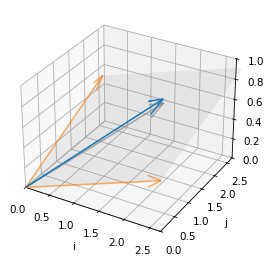

In [86]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

plot_plane(v1, v2, alpha=0.08)
plot_vectors([v1, v2], color='C1')
plot_vectors([y], alpha=1)
plot_vectors([y_hat], color='gray')

lim = [0, 2.7]
decorate(xlim=lim, ylim=lim, zlim=[0, 1], xlabel='i', ylabel='j', zlabel='k')

In [87]:
X.T @ r

array([-2.16 , -3.176])

## QR Decomposition

In [88]:
Q, R = np.linalg.qr(X)
Q

array([[-5.7735e-01,  7.0711e-01],
       [-5.7735e-01,  5.5511e-17],
       [-5.7735e-01, -7.0711e-01]])

In [89]:
R

array([[-1.7321, -1.9053],
       [ 0.    ,  1.4142]])

In [90]:
np.allclose(X, Q @ R)

True

In [91]:
Q.T @ Q

array([[ 1.0000e+00, -1.1622e-16],
       [-1.1622e-16,  1.0000e+00]])

That means that `Q` is its own inverse, which means we can solve the equation $Q \beta' = y$ by multiplying both sides by $Q^T$, which yields $Q^T Q \beta' = Q^T y$, which yields $\beta' = Q^T y$.

The result is the coordinates of y in 

In [92]:
beta_prime = Q.T @ y
beta_prime

array([-2.3902,  0.8485])

In [93]:
y_hat = Q @ beta_prime
y_hat

array([1.98, 1.38, 0.78])

Combine two steps into one

In [94]:
P = Q @ Q.T
P

array([[ 0.8333,  0.3333, -0.1667],
       [ 0.3333,  0.3333,  0.3333],
       [-0.1667,  0.3333,  0.8333]])

In [95]:
y_hat = P @ y
y_hat

array([1.98, 1.38, 0.78])

In [96]:
P @ v1

array([1., 1., 1.])

In [97]:
P @ v2

array([2.1, 1.1, 0.1])

Which shows that the plane spanned by Q is the same as the plane spanned by X.

In [98]:
q1, q2 = Q.T

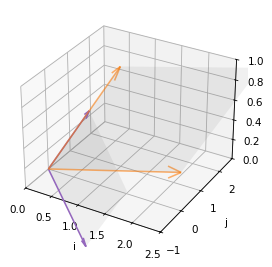

In [99]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

plot_plane(v1, v2, alpha=0.08)
plot_plane(-q1, q2, alpha=0.08)
plot_vectors([v1, v2], color='C1')
plot_vectors([-q1, q2], color='C4', alpha=1)

lim = [0, 2.5]
decorate(xlim=lim, ylim=[-1, 2.7], zlim=[0, 1], xlabel='i', ylabel='j', zlabel='k')

Because columns of \(Q\) are orthonormal, the least-squares problem reduces to:

$$
\min_\beta \lVert Q R \beta - y \rVert 
= \min_\beta \lVert R \beta - Q^\top y \rVert
$$

Solve the triangular system:

$$
R \beta = Q^\top y
$$


In [100]:
# Because columns of Q are orthonormal, the least-squares problem reduces to:
#   min ||Q R β - y|| = min ||R β - Q^T y||
# Solve the triangular system R β = Q^T y

from scipy.linalg import solve_triangular

beta_qr = solve_triangular(R, beta_prime, lower=False)
beta_qr

array([0.72, 0.6 ])

## Orthogonalization

In [41]:
from utils import norm, normalize

v1, v2 = X.T
norm(v1)

1.7321

In [42]:
v1_hat = normalize(v1)
v1_hat

array([0.5774, 0.5774, 0.5774])

In [43]:
v2_perp = v2 - vector_projection(v2, v1)

In [44]:
v2_hat = normalize(v2_perp)
v2_hat

array([ 0.7071,  0.    , -0.7071])

In [45]:
v1 @ v2_perp

0.0000

In [46]:
Q = np.column_stack([v1_hat, v2_hat])
Q

array([[ 0.5774,  0.7071],
       [ 0.5774,  0.    ],
       [ 0.5774, -0.7071]])

In [47]:
Q.T @ Q

array([[ 1.0000e+00, -1.7796e-17],
       [-1.7796e-17,  1.0000e+00]])

In [ ]:
def gram_schmidt(X):
    """
    Classical Gram-Schmidt.

    Args:
        X: array (m, n) with n input vectors as columns.

    Returns:
        Q: (m, n) with orthonormal columns
        R: (n, n) upper triangular
    """
    m, n = X.shape
    Q = np.zeros((m, n))
    R = np.zeros((n, n))

    for j in range(n):
        v = X[:, j].copy()
        for i in range(j):
            R[i, j] = np.dot(Q[:, i], X[:, j])
            v = v - R[i, j] * Q[:, i]
        R[j, j] = np.linalg.norm(v)
        Q[:, j] = v / R[j, j]
    
    return Q, R

In [57]:
Q, R = gram_schmidt(X)
Q

array([[ 5.7735e-01,  7.0711e-01],
       [ 5.7735e-01, -1.5701e-16],
       [ 5.7735e-01, -7.0711e-01]])

In [49]:
R

array([[1.7321, 1.9053],
       [0.    , 1.4142]])

In [58]:
np.allclose(Q @ R, X)

True

## Putting it together

In [101]:
def lstsq(X, y):
    Q, R = gram_schmidt(X)
    beta = solve_triangular(R, Q.T @ y, lower=False)
    return beta

In [102]:
lstsq(X, y)

array([0.72, 0.6 ])

In [104]:
import scipy

beta, _, rank, _ = scipy.linalg.lstsq(X, y, lapack_driver='gelsy')
beta

array([0.72, 0.6 ])

In [105]:
rank

2

[Think Linear Algebra](https://allendowney.github.io/ThinkLinearAlgebra/index.html)

Copyright 2025 [Allen B. Downey](https://allendowney.com)

Code license: [MIT License](https://mit-license.org/)

Text license: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)